# This notebook helps explain the celerite normalization (variance)

In [1]:
import celerite
import corner
from celerite.terms import Matern32Term, JitterTerm
from mind_the_gaps.models.celerite_models import DampedRandomWalk as DRW, Lorentzian
from mind_the_gaps.models.psd_models import BendingPowerlaw as BPL, SHO, Lorentzian as Lor, Matern32, Jitter
from mind_the_gaps.simulator import Simulator
from mind_the_gaps.lightcurves import GappyLightcurve
from mind_the_gaps.gpmodelling import GPModelling
import corner
import astropy.units as u
from mind_the_gaps.simulator import *
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

def log_probability(params):
    """https://celerite.readthedocs.io/en/stable/tutorials/modeling/"""
    gp.set_parameter_vector(params)

    lp = gp.log_prior()
    if not np.isfinite(lp):
        return -np.inf
    return lp + gp.log_likelihood(y)

cores = 12

In [3]:
normalization_factor =  2 / np.sqrt(2 * np.pi) # this factor accounts for the fact that we only integrate positive frequencies and the 1 / sqrt(2pi) from the Fourier transform

# Generate lightcurve with given variance and a DRW

Lightcurve duration: 5001.25
SIMULATING


/Users/oliviergilbert/Library/Python/3.9/lib/python/site-packages/stingray/utils.py:403: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


Model variance: 1.00000
Integrated variance: 0.99204
Sample Variance: 0.97944


Text(0.5, 0, 'Period')

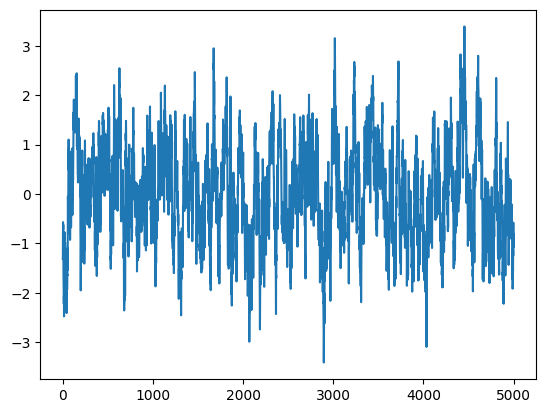

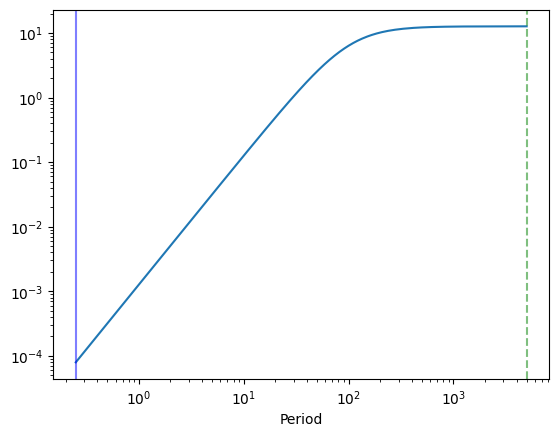

In [4]:
np.random.seed(45)
Npoints = 5000
times = np.linspace(0, 5000, Npoints)
exposures = 0.5 * np.ones(Npoints) 
duration = times[-1] + 1.5 * exposures[-1] - (times[0] - exposures[0])
print("Lightcurve duration: %.2f" % (duration))
sim_dt = 1 / 2 * np.min(exposures)

logS0 = 0
S0 = np.exp(logS0)
break_timescale = 100
w0 = 2 * np.pi / break_timescale
logw0 = np.log(w0)
psd_model = BPL(S0=S0, omega0=w0)
minimum_frequency = 1 / (duration)
maximum_frequency = 1 / (sim_dt)
fnyq = maximum_frequency

extension_factor = 1.0
df_int = 1 / (duration * extension_factor)
int_freq = np.arange(minimum_frequency, fnyq, df_int) # frequencies over which to integrate
w_int = int_freq * 2 * np.pi
var = np.sum(psd_model(w_int)) * df_int * 2 * np.pi * normalization_factor

simulator = Simulator(psd_model, times, exposures, mean=0, pdf="Gaussian", extension_factor=extension_factor)
rates = simulator.generate_lightcurve()

#lc = simulate_lightcurve(times, psd_model, dt=0.5, 
 #                        extension_factor=extension_factor)

#segment = cut_random_segment(lc, duration)
#plt.plot(segment.time, segment.countrate)
plt.plot(times, rates)
plt.gca().ticklabel_format(useOffset=False)
print("Model variance: %.5f" % S0)
print("Integrated variance: %.5f" % var)
#print("LC variance: %.5f" % np.var(lc.countrate))
print("Sample Variance: %.5f" % np.var(rates))

plt.figure()
plt.plot(1 / int_freq, psd_model(w_int))
plt.axvline(1 / minimum_frequency, color="green", alpha=0.5, ls="--")
plt.axvline(1 / maximum_frequency, alpha=0.5, color="blue")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Period")

# Fit it with celerite

In [5]:

y = rates
time = times
S0 = np.var(rates)
y = rates
time = times
S0 = np.var(rates)
S_0_N_bounds = (-10, 10)
log_omega0_N_bounds = (-10, 10)
bounds = dict(log_S0=S_0_N_bounds, log_omega0=log_omega0_N_bounds)
kernel = DRW(log_S0=np.log(S0), log_omega0=np.log(w0),
                                 bounds=bounds)
cols = ["kernel:log_S0", "kernel:log_omega0"]
labels = [r"log $S_N$", r"log $\omega_N$"]
gpmodel = GPModelling(GappyLightcurve(times, rates, dy=np.ones(len(rates)) * 1e-12), kernel)

fit

In [6]:
gpmodel.derive_posteriors(max_steps=50000, fit=True, cores=cores)

 10%|█         | 5000/50000 [00:27<04:06, 182.80it/s]


Convergence reached after 5000 samples!


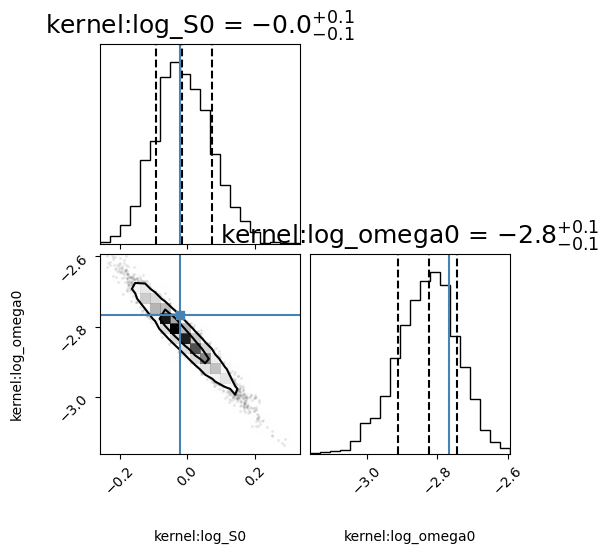

In [7]:
corner_fig = corner.corner(gpmodel.mcmc_samples, labels=gpmodel.gp.get_parameter_names(), title_fmt='.1f',
                            quantiles=[0.16, 0.5, 0.84], show_titles=True, truths=[np.log(S0), logw0],
                            title_kwargs={"fontsize": 18}, max_n_ticks=3, labelpad=0.08,
                            levels=(1 - np.exp(-0.5), 1 - np.exp(-0.5 * 2 ** 2))) # plots 1 and 2 sigma levels


('kernel:log_S0', 'kernel:log_omega0', 'mean:value')
[-0.01931432 -2.82021887]
Ratio ampltiudes
1.0014653413699102
Ratio breaks
0.9484504334882822


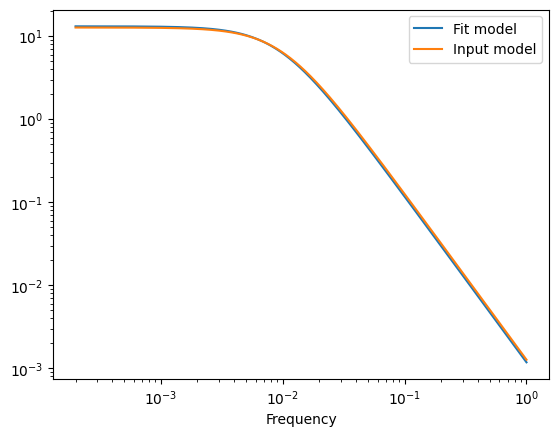

In [8]:
print(gpmodel.gp.parameter_names)
print(gpmodel.max_parameters)
df = 1 / (duration)
fnyq = 1 / (2 * exposures[0])
frequencies = np.arange(df, fnyq, df)
w = frequencies * 2 * np.pi

kernel.set_parameter_vector(gpmodel.max_parameters)
psd = kernel.get_psd(w)
plt.plot(frequencies, psd, label="Fit model")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Frequency")

kernel.set_parameter_vector((logS0, logw0))
psd = kernel.get_psd(w)
plt.plot(frequencies, psd, label="Input model")
plt.legend()
print("Ratio ampltiudes")
print(np.exp(gpmodel.max_parameters[0]) / S0)
print("Ratio breaks")
print(np.exp(gpmodel.max_parameters[1]) / w0)

# Same thing but with a Lorentizan now

Lightcurve duration: 5001.25
SIMULATING


/Users/oliviergilbert/Library/Python/3.9/lib/python/site-packages/stingray/utils.py:403: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


Model variance: 1.00000
Integrated variance: 0.99921
Sample Variance: 0.96208


Text(0.5, 0, 'Period')

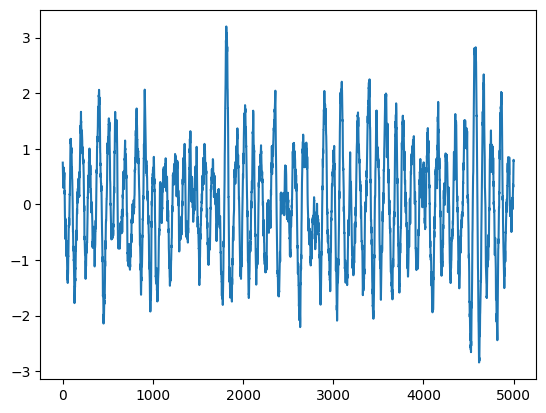

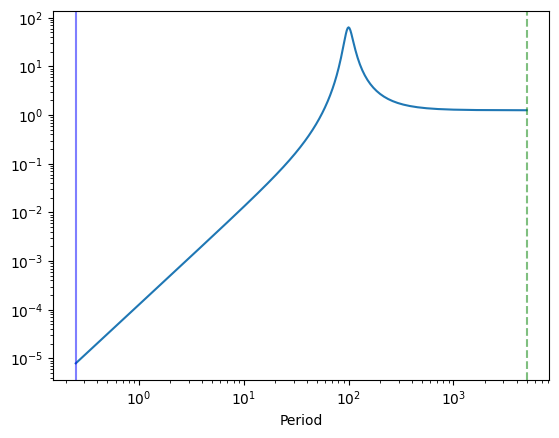

In [9]:
np.random.seed(4)
Npoints = 5000
times = np.linspace(0, 5000, Npoints)
exposures = 0.5 * np.ones(Npoints) 
duration = times[-1] + 1.5 * exposures[-1] - (times[0] - exposures[0])
print("Lightcurve duration: %.2f" % (duration))
sim_dt = 1 / 2 * np.min(exposures)


logS0 = 0
S0 = np.exp(logS0)
break_timescale = 100
w0 = 2 * np.pi / break_timescale
logw0 = np.log(w0)
minimum_frequency = 1 / (duration)
maximum_frequency = 1 / (sim_dt)
fnyq = maximum_frequency
Q = 5
logQ = np.log(Q)
psd_model = Lor(S0=S0, omega0=w0, Q=Q)

extension_factor = 1.0
df_int = 1 / (duration * extension_factor)
int_freq = np.arange(minimum_frequency, fnyq, df_int) # frequencies over which to integrate
w_int = int_freq * 2 * np.pi
var = np.sum(psd_model(w_int)) * df_int * 2 * np.pi * normalization_factor

simulator = Simulator(psd_model, times, exposures, mean=0, pdf="Gaussian", extension_factor=extension_factor)
rates = simulator.generate_lightcurve()

#lc = simulate_lightcurve(times, psd_model, dt=0.5, 
 #                        extension_factor=extension_factor)

#segment = cut_random_segment(lc, duration)
#plt.plot(segment.time, segment.countrate)
plt.plot(times, rates)
plt.gca().ticklabel_format(useOffset=False)
print("Model variance: %.5f" % S0)
print("Integrated variance: %.5f" % var)
#print("LC variance: %.5f" % np.var(lc.countrate))
print("Sample Variance: %.5f" % np.var(rates))

plt.figure()
plt.plot(1 / int_freq, psd_model(w_int))
plt.axvline(1 / minimum_frequency, color="green", alpha=0.5, ls="--")
plt.axvline(1 / maximum_frequency, alpha=0.5, color="blue")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Period")

# Prepare fit with celerite

In [10]:
y = rates
time = times
S0 = np.var(rates)
S_0_N_bounds = (-10, 10)
Q = 200
log_omega0_N_bounds = (-10, 1)
log_Q_bounds = (np.log(1.5), np.log(5000))

bounds = dict(log_S0=S_0_N_bounds, log_omega0=log_omega0_N_bounds, log_Q=log_Q_bounds)
kernel = Lorentzian(log_S0=np.log(S0), log_omega0=np.log(w0), log_Q=np.log(Q),
                                 bounds=bounds)
cols = ["kernel:log_S0", "kernel:log_omega0", "kernel:log_Q"]
labels = [r"log $S_N$", r"log $\omega_N$", "log_Q"]
gpmodel = GPModelling(GappyLightcurve(times, rates, dy=np.ones(len(rates)) * 1e-12), kernel)

# fit 

In [11]:
gpmodel.derive_posteriors(max_steps=50000, fit=True, cores=cores)

 26%|██▌       | 13000/50000 [01:39<04:44, 130.14it/s]


Convergence reached after 13000 samples!


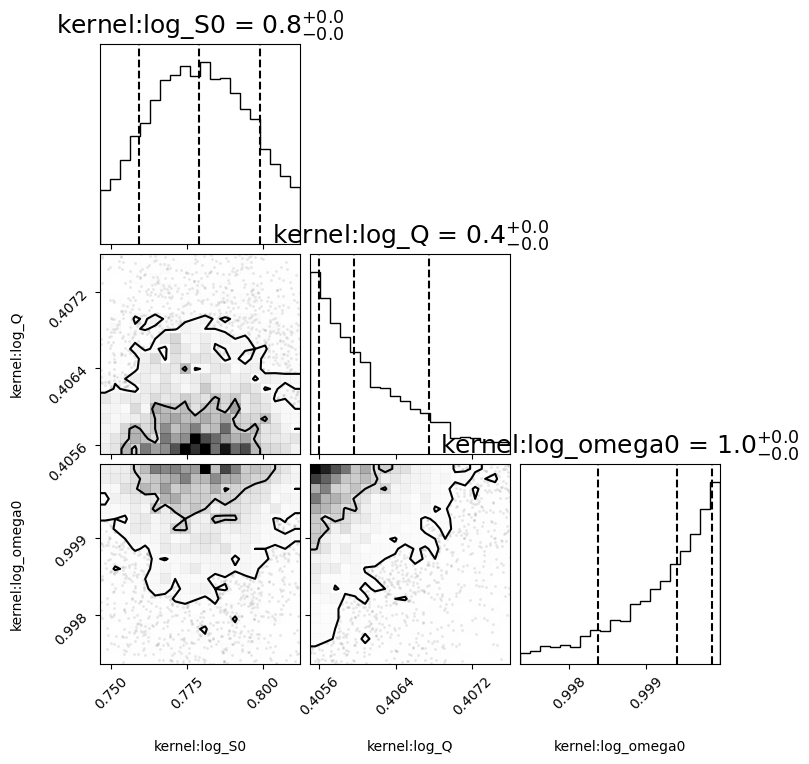

In [12]:
corner_fig = corner.corner(gpmodel.mcmc_samples, labels=gpmodel.gp.get_parameter_names(), title_fmt='.1f',
                            quantiles=[0.16, 0.5, 0.84], show_titles=True, truths=[np.log(S0), np.log(Q), np.log(w0)],
                            title_kwargs={"fontsize": 18}, max_n_ticks=3, labelpad=0.08, range=0.9 * np.ones(gpmodel.k),
                            levels=(1 - np.exp(-0.5), 1 - np.exp(-0.5 * 2 ** 2))) # plots 1 and 2 sigma levels


('kernel:log_S0', 'kernel:log_Q', 'kernel:log_omega0', 'mean:value')
[0.77401762 0.40548518 0.99999279]
Ratio ampltiudes
2.2539296610295243
Ratio breaks
43.262487031754894


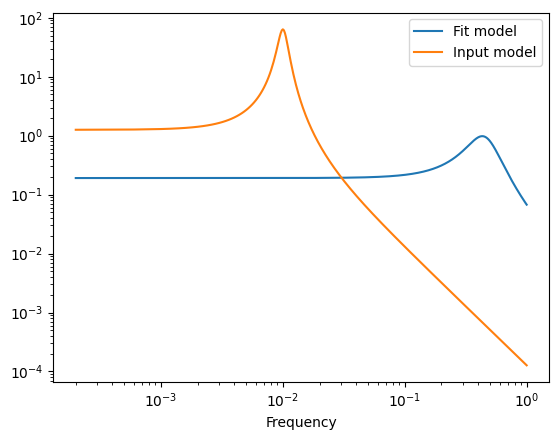

In [13]:
print(gpmodel.gp.parameter_names)
print(gpmodel.max_parameters)
df = 1 / (duration)
fnyq = 1 / (2 * exposures[0])
frequencies = np.arange(df, fnyq, df)
w = frequencies * 2 * np.pi


kernel.set_parameter_vector(gpmodel.max_parameters)
psd = kernel.get_psd(w)
plt.plot(frequencies, psd, label="Fit model")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Frequency")

kernel.set_parameter_vector((logS0, logQ, logw0))
psd = kernel.get_psd(w)
plt.plot(frequencies, psd, label="Input model")
plt.legend()
print("Ratio ampltiudes")
print(np.exp(gpmodel.max_parameters[0]) / S0)
print("Ratio breaks")
print(np.exp(gpmodel.max_parameters[2]) / w0)

# Same with Matern

Lightcurve duration: 5001.25
Period: 1.61 d
SIMULATING


/Users/oliviergilbert/Library/Python/3.9/lib/python/site-packages/stingray/utils.py:403: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


Model variance: 0.96208
Integrated variance: 0.00000
Sample Variance: 0.00001


Text(0.5, 0, 'Period')

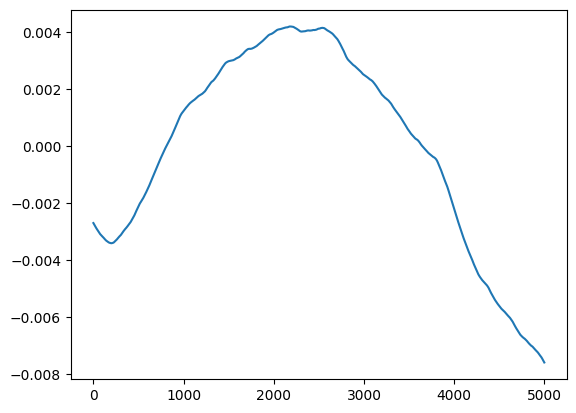

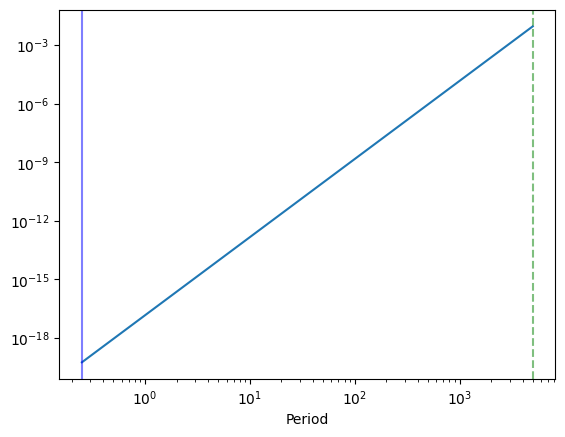

In [14]:
np.random.seed(4)
Npoints = 5000
times = np.linspace(0, 5000, Npoints)
exposures = 0.5 * np.ones(Npoints) 
duration = times[-1] + 1.5 * exposures[-1] - (times[0] - exposures[0])
print("Lightcurve duration: %.2f" % (duration))
sim_dt = 1 / 2 * np.min(exposures)

logS0 = 1
sigma = np.exp(logS0)
logrho = np.log(32.17 / 20 * 3600 * 24)
rho = np.exp(logrho)
break_timescale = rho / 3600 / 24 
print("Period: %.2f d" % break_timescale)
psd_model = Matern32(sigma=sigma, rho=rho)
minimum_frequency = 1 / (duration)
maximum_frequency = 1 / (sim_dt)
fnyq = maximum_frequency

extension_factor = 10
df_int = 1 / (duration * extension_factor)
int_freq = np.arange(minimum_frequency, fnyq, df_int) # frequencies over which to integrate
w_int = int_freq * 2 * np.pi
var = np.sum(psd_model(w_int)) * df_int * 2 * np.pi * normalization_factor


simulator = Simulator(psd_model, times, exposures, mean=0, pdf="Gaussian", extension_factor=extension_factor)
rates = simulator.generate_lightcurve()

plt.plot(times, rates)
plt.gca().ticklabel_format(useOffset=False)
print("Model variance: %.5f" % S0)
print("Integrated variance: %.5f" % var)
#print("LC variance: %.5f" % np.var(lc.countrate))
print("Sample Variance: %.5f" % np.var(rates))

plt.figure()
plt.plot(1 / int_freq, psd_model(w_int))
plt.axvline(1 / minimum_frequency, color="green", alpha=0.5, ls="--")
plt.axvline(1 / maximum_frequency, alpha=0.5, color="blue")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Period")

# Jitter

In [16]:
Npoints = 1000
times = np.linspace(0, 1000, Npoints) * 3600 * 24 # seconds
exposures = 2000 * np.ones(Npoints) # seconds
duration = times[-1] + 1.5 * exposures[-1] - (times[0] - exposures[0])
print("Lightcurve duration: %.2f d" % (duration / 3600 /24))
aliasing_factor = 1
sim_dt = np.min(exposures) / aliasing_factor

logS0 = 2
sigma = np.exp(logS0)
psd_model = Jitter(sigma=sigma)
minimum_frequency = 1 / (duration)
maximum_frequency = 1 / (sim_dt)
fnyq = maximum_frequency

extension_factor = 2
df_int = 1 / (duration * extension_factor)
int_freq = np.arange(minimum_frequency, fnyq, df_int) # frequencies over which to integrate

w_int = int_freq * 2 * np.pi
print(psd_model(w_int))
var = np.sum(psd_model(w_int)) * (df_int * 2 * np.pi) * normalization_factor
simulator = Simulator(psd_model, times, exposures, mean=0, pdf="Gaussian", extension_factor=extension_factor, 
                      aliasing_factor=aliasing_factor)
# Note the power is diluted by a factor aliasing_factor, if you want the lightcurve with the original variance, you need to simulate the regularly sampled lightcurve
rates = simulator.generate_lightcurve()

#lc = simulate_lightcurve(times, psd_model, dt=0.5, 
 #                        extension_factor=extension_factor)

#segment = cut_random_segment(lc, duration)
#plt.plot(segment.time, segment.countrate)
plt.plot(times, rates)
plt.gca().ticklabel_format(useOffset=False)
print("Model variance: %.5f" % sigma**2)
print("Integrated variance: %.5f" % var)
print("Sample Variance: %.5f" % np.var(rates))

plt.figure()
plt.plot(1 / int_freq, psd_model(w_int))
plt.axvline(1 / minimum_frequency, color="green", alpha=0.5, ls="--")
plt.axvline(1 / maximum_frequency, alpha=0.5, color="blue")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Period")

Lightcurve duration: 1000.06 d


KeyError: 'x'

fit with celerite

In [17]:
y = rates
time = times
S0 = np.var(y)
nwalkers = 12
kernel = JitterTerm(log_sigma=np.log(3))

gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(time)  # You always need to call compute once.
initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()
solution = minimize(neg_log_like, 
                    initial_params, method="L-BFGS-B", bounds=gp.get_parameter_bounds(), args=(y, gp))
print(solution)

ValueError: dimension mismatch

In [18]:
print(gp.parameter_names)
print(solution.x)
frequencies = np.arange(df_int, fnyq, df_int)
w = frequencies * 2 * np.pi
gp.set_parameter_vector(solution.x)
psd = gp.kernel.get_psd(w)
plt.plot(frequencies, psd, label="Fit model")

gp.set_parameter_vector((logS0))
psd = gp.kernel.get_psd(w)
plt.plot(frequencies, psd, label="Input model")
plt.legend()
print("Ratio ampltiudes")
print(np.exp(solution.x)[0] / np.exp(logS0))

('kernel:log_sigma', 'mean:value')


NameError: name 'solution' is not defined

# Generate lightcurves with different lengths --> dispersion on the variance should go up

In [19]:
np.random.seed(42)

n = 50 # simulations to perform per sampling
#### Model ###
logS0 = 0
S0 = np.exp(logS0)
logw0 = -13
w0 = np.exp(logw0)
break_timescale = 1 / (w0 / 2 / np.pi) / 3600 / 24 
print("Break timescale: %.2f d" % break_timescale)
psd_model = BPL(S_0=S0, w_0=np.exp(-13))

### Lightcurve N = 1000 ###
Npoints = 1000
length = 1000
times = np.linspace(0, length, Npoints) * 3600 * 24 # seconds
exposures = 1000 * np.ones(Npoints) # seconds
duration = times[-1] + 1.5 * exposures[-1] - (times[0] - exposures[0])
sim_dt = 1 / 10 * np.min(exposures)
print("Lightcurve duration: %.2f d" % (duration / 3600 /24))

minimum_frequency = 1 / (duration)
maximum_frequency = 1 / (sim_dt)
fnyq = maximum_frequency
extension_factor = 5
df_int = 1 / (duration * extension_factor)
int_freq = np.arange(minimum_frequency, fnyq, df_int) # frequencies over which to integrate
w_int = int_freq * 2 * np.pi
normalization_factor =  2 / np.sqrt(2 * np.pi) # this factor accounts for the fact that we only integrate positive frequencies and the 1 / sqrt(2pi) from the Fourier transform
var = np.sum(psd_model(w_int)) * df_int * 2 * np.pi * normalization_factor
print("Integrated variance: %.5f" % var)

variances = []
for i in range(n): 
    lc = simulate_lightcurve(times, psd_model,
                        dt=sim_dt, 
                         extension_factor=extension_factor)

    segment = cut_random_segment(lc, duration)
    variances.append(np.var(segment.countrate))
print("Dispersion for %d length: %.3f" % (length, np.std(variances)))
# plot results
plt.hist(variances, label="L = %d" % (length), facecolor="None", edgecolor="C0")
### Lightcurve N = 1000 ###
length=100
times = np.linspace(0, length, Npoints) * 3600 * 24 # seconds
exposures = 1000 * np.ones(Npoints) # seconds
duration = times[-1] + 1.5 * exposures[-1] - (times[0] - exposures[0])
sim_dt = 1 / 10 * np.min(exposures)
print("Lightcurve duration: %.2f d" % (duration / 3600 /24))    

minimum_frequency = 1 / (duration)

df_int = 1 / (duration * extension_factor)
int_freq = np.arange(minimum_frequency, fnyq, df_int) # frequencies over which to integrate
w_int = int_freq * 2 * np.pi
normalization_factor =  2 / np.sqrt(2 * np.pi) # this factor accounts for the fact that we only integrate positive frequencies and the 1 / sqrt(2pi) from the Fourier transform
var = np.sum(psd_model(w_int)) * df_int * 2 * np.pi * normalization_factor
print("Integrated variance: %.5f" % var)

variances = []
for i in range(n): 
    lc = simulate_lightcurve(times, psd_model,
                        dt=sim_dt, 
                         extension_factor=extension_factor)

    segment = cut_random_segment(lc, duration)
    variances.append(np.var(segment.countrate))
plt.hist(variances, label="L = %d" % (length), facecolor="None", edgecolor="C1")
print("Dispersion for %d length: %.3f" % (length, np.std(variances)))
plt.legend()
plt.xlabel("$\sigma^2$ (ct/s)$^2$")

Break timescale: 32.17 d


TypeError: BendingPowerlaw.__init__() got an unrecognized parameter 'S_0'

In [20]:
%matplotlib inline
Npoints = 1000
times = np.linspace(0, 1000, Npoints) * 3600 * 24 # seconds
exposures = 1000 * np.ones(Npoints) # seconds
duration = times[-1] + 1.5 * exposures[-1] - (times[0] - exposures[0])
print("Lightcurve duration: %.2f d" % (duration / 3600 /24))
sim_dt = 1 / 10 * np.min(exposures)

logS0 = 0
S0 = np.exp(logS0)
logw0 = -13
w0 = np.exp(logw0)
logQ = np.log(1000)
Q = np.exp(logQ)
break_timescale = 1 / (w0 / 2 / np.pi) / 3600 / 24 
print("Period: %.2f d" % break_timescale)
print("log_Q: %.3f" % (logQ))
psd_model = Lor(S_0=S0, w_0=w0, Q=Q)
minimum_frequency = 1 / (duration)
maximum_frequency = 1 / (sim_dt)
fnyq = maximum_frequency

extension_factor = 10
df_int = 1 / (duration * extension_factor)
int_freq = np.arange(minimum_frequency, fnyq, df_int) # frequencies over which to integrate
w_int = int_freq * 2 * np.pi
normalization_factor =  2 / np.sqrt(2 * np.pi) # this factor accounts for the fact that we only integrate positive frequencies and the 1 / sqrt(2pi) from the Fourier transform
var = np.sum(psd_model(w_int)) * df_int * 2 * np.pi * normalization_factor

n = 50
variances = []
for i in range(n):
    lc = simulate_lightcurve(times, psd_model,
                            dt=sim_dt, 
                             extension_factor=extension_factor)

    segment = cut_random_segment(lc, duration)
    variances.append(np.var(segment.countrate))

plt.figure()
plt.hist(variances)
plt.axvline(np.mean(variances))
plt.xlabel("$\sigma^2")
print("Dispersion in variance: %.2f" % np.std(variances))
print("Mean variance: %.2f" % np.mean(variances))

Lightcurve duration: 1000.03 d
Period: 32.17 d
log_Q: 6.908


TypeError: Lorentzian.__init__() got an unrecognized parameter 'S_0'

# Simulate from solution

In [21]:
duration = (times + 1.5 * exposures[-1] - (times[0] - exposures[0]))

sim_dt = 1 / 10 * np.min(exposures)
mean = np.mean(y)
std = np.std(y)
Q = 1 / 2
psd_model = BPL(S0=np.exp(logS0), omega0=np.exp(logw0), Q=Q)
extension_factor = 20
lc = simulate_lightcurve(times, psd_model,
                        dt=sim_dt, 
                         extension_factor=extension_factor) # this is just to get tseg for df
plt.plot(lc.time, lc.countrate)
plt.gca().ticklabel_format(useOffset=False)

NameError: name 'simulate_lightcurve' is not defined

In [22]:
print("Generated variance: %.2f" % np.var(lc.countrate))

NameError: name 'lc' is not defined

In [23]:
psd_model = BPL(S_0=np.exp(logS0) * lc.dt * lc.n / 2, w_0=np.exp(logw0), Q=Q)
lc = simulate_lightcurve(timestamps.to(u.s).value, psd_model,
                        dt=sim_dt.to(u.s).value, 
                         extension_factor=extension_factor) # this is just to get tseg for df
plt.plot(lc.time, lc.countrate)
print(np.var(lc.countrate))

NameError: name 'lc' is not defined

In [24]:
y = lc.countrate
time = lc.time
Q = 1/ 2
w0 = 2 * np.pi / (10 * u.d).to(u.s).value
S0 = np.var(y) / (w0 * Q)
S_0_N_bounds = (-20, 5)
log_omega0_N_bounds = (-20, -5)  # 0 to 200 in period (days)
nwalkers = 12
bounds = dict(log_S0=S_0_N_bounds, log_omega0=log_omega0_N_bounds)
kernel = BPL_celerite(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                                 bounds=bounds)
kernel.freeze_parameter("log_Q")
initial_samples = np.array([np.random.uniform(S_0_N_bounds[0], S_0_N_bounds[1], nwalkers),
                           np.random.uniform(log_omega0_N_bounds[0], log_omega0_N_bounds[1], nwalkers)])
cols = ["kernel:log_S0", "kernel:log_omega0"]
labels = [r"log $S_N$", r"log $\omega_N$"]
initial_samples = initial_samples.T

NameError: name 'lc' is not defined

In [25]:
gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(time)  # You always need to call compute once.
initial_params = gp.get_parameter_vector()
par_names = list(gp.get_parameter_names())
bounds = gp.get_parameter_bounds()
solution = minimize(neg_log_like, 
                    initial_params, method="L-BFGS-B", bounds=gp.get_parameter_bounds(), args=(y, gp))

ValueError: dimension mismatch

In [26]:
print(solution.x)
df = 1 / (lc.tseg)
fnyq = 1 / (2 * lc.dt)
frequencies = np.arange(df, fnyq, df)
w = frequencies * 2 * np.pi

NameError: name 'solution' is not defined

In [27]:
print(gp.parameter_names)
gp.set_parameter_vector(solution.x)
psd = gp.kernel.get_psd(w)
plt.plot(frequencies, psd, label="Fit model")
plt.yscale("log")
plt.xscale("log")

gp.set_parameter_vector((logS0, logw0))
psd = gp.kernel.get_psd(w)
plt.plot(frequencies, psd, label="Input model")
plt.legend()
print("Ratio ampltiudes")
print(np.exp(solution.x)[0] / np.exp(logS0))
print("Ratio breaks")
print(np.exp(solution.x)[1] / np.exp(logw0))

('kernel:log_sigma', 'mean:value')


NameError: name 'solution' is not defined

# Bowman et al 2020 gives the std of the SHO

In [28]:
from mind_the_gaps.lightcurves.stingray import PatchedLightcurve as Lightcurve
import numexpr as ne
import pyfftw
from astropy.stats import poisson_conf_interval

def simulate_lightcurve_(timestamps, psd_model, dt, extension_factor=50):
    """Simulate a lightcurve regularly sampled N times longer than original using the algorithm of Timmer & Koenig+95

    Parameters
    ----------
    timestamps: array
        Timestamps, same units as dt
    psd_model: astropy.model
        The model for the PSD. Has to take angular frequencies
    dt: float
        Binning to which simulate the lightcurve in seconds
    extension_factor: int
        How many times longer than original
    """
    if exddtension_factor < 1:
        raise ValueError("Extension factor needs to be higher than 1")

    duration = timestamps[-1] - timestamps[0]
    # generate timesctamps sampled at the median exposure longer than input lightcurve by extending the end
    sim_timestamps = np.arange(timestamps[0] - 2 * dt,
                               timestamps[0] + duration * extension_factor + dt,
                               dt)

    n_datapoints = len(sim_timestamps)

    complex_fft = get_fft(n_datapoints, dt, psd_model)

    countrate = pyfftw.interfaces.numpy_fft.irfft(complex_fft, n=n_datapoints) # it does seem faster than numpy although only slightly
    
    countrate *= np.sqrt(n_datapoints) * np.sqrt(dt) * np.sqrt(np.sqrt(2 * np.pi))
    
    return Lightcurve(sim_timestamps, countrate, input_counts=True, skip_checks=True, dt=dt, err_dist="gauss")

ModuleNotFoundError: No module named 'mind_the_gaps.lightcurves.stingray'

In [ ]:
data = readPCCURVE('%s/xray_data/%s/lc/PCCURVE.qdp' % (home, ulx_dir),
                   minSNR=0)

time_column = data.dtype.names[0]
filtered_data = data[np.where((data["%s" % time_column] >= tmin) &
                              (data["%s" % time_column] <= tend))]
exposure_column = data.dtype.names[12]

timestamps = filtered_data[time_column]
if time_column == 'MJD':
            units = u.d
else:
    units = u.s
timestamps = filtered_data[time_column] * units
rate_column = data.dtype.names[3]
corr_factor = data.dtype.names[9]
bkg_counts_column = data.dtype.names[11]
y_units = u.ct / u.s
rate = filtered_data[rate_column] * y_units
errors = (-filtered_data["%sneg" % rate_column] +
          filtered_data["%spos" % rate_column]) / 2 * y_units
corr_factor = filtered_data[corr_factor]
exposures = filtered_data[exposure_column] * u.s / corr_factor
bkg_counts = filtered_data[bkg_counts_column] << u.ct
half_bins = exposures / 2
duration = (timestamps[-1] + 1.5 * exposures[-1] - (timestamps[0] - exposures[0])).to(u.s).value

sim_dt = 1 / 2 * np.min(exposures)
logS0 = 3
bend = 60 * 3600 * 24 # 55 days to seconds
logw0 = np.log(2 * np.pi / bend) # rad/s
Q = 1 / 2
psd_model = BPL(S_0=np.exp(logS0), w_0=np.exp(logw0))
extension_factor = 15
lc = simulate_lightcurve_(timestamps.to(u.s).value, psd_model,
                        dt=sim_dt.to(u.s).value, 
                         extension_factor=extension_factor) # this is just to get tseg for df
plt.plot(lc.time, lc.countrate)
print("Lightcurve duration: %.2f days" %(lc.tseg / 3600 / 24))

In [ ]:
#variance = psd_model.S_0 * psd_model.w_0 / np.sqrt(2)
variance = psd_model.S_0.value
print("Theoretical variance: %.8f"  % variance)
#var_factor = 1 / lc.dt**2
#var_factor = lc.n * (lc.dt)
var_factor = lc.n * lc.dt
var_factor = 1
factor = np.sqrt(2 * np.pi)
factor = 1
print("Lightcurve variance: %.8f" % (np.var(lc.countrate) * var_factor * factor))
df = 1 / (lc.tseg)
fnyq = 1 / (2 * lc.dt)
frequencies = np.arange(df, fnyq, df)
w_int = frequencies * 2 * np.pi
factor = 4 / np.sqrt(2 / np.pi)
factor = 2 * np.sqrt(2 * np.pi)
factor = 2 / np.sqrt(2 * np.pi)
integrated_variance = np.sum(psd_model(w_int) * df) * factor * 2 * np.pi   # * factor  * 2 * np.pi  
print("Integrated variance: %.8f" % integrated_variance)

# Fit data with celerite

In [ ]:
y = lc.countrate
time = lc.time

S_0_N_bounds = (logS0 - 5, logS0 + 5)
log_omega0_N_bounds = (logw0-5, logw0+5)  # 0 to 200 in period (days)
nwalkers = 12
bounds = dict(log_S0=S_0_N_bounds, log_omega0=log_omega0_N_bounds)
kernel = DRW(log_S0=logS0, log_omega0=logw0,
                                 bounds=bounds)
initial_samples = np.array([np.random.uniform(S_0_N_bounds[0], S_0_N_bounds[1], nwalkers),
                           np.random.uniform(log_omega0_N_bounds[0], log_omega0_N_bounds[1], nwalkers)])
cols = ["kernel:log_S0", "kernel:log_omega0"]
labels = [r"log $S_N$", r"log $\omega_N$"]
initial_samples = initial_samples.T
gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(time)  # You always need to call compute once.
initial_params = gp.get_parameter_vector()
par_names = list(gp.get_parameter_names())
bounds = gp.get_parameter_bounds()
solution = minimize(neg_log_like, 
                    initial_params, method="L-BFGS-B", 
                    bounds=gp.get_parameter_bounds(), 
                    args=(y, gp))
print(solution.x)
power = gp.kernel.get_psd(1 / lc.time * 2 * np.pi)
plt.plot(1 / time, power, color="blue")
plt.plot(1/time, psd_model(1 / lc.time * 2 * np.pi), label="Input")
plt.axvline(1 / bend, ls="--", color="black")
plt.axvline(np.exp(solution.x[1]) / 2 / np.pi, ls="solid", color="blue", label="Found")
plt.xscale("log")
plt.yscale("log")
plt.legend()

In [ ]:
power = gp.kernel.get_psd(1 / lc.time * 2 * np.pi)
plt.plot(1 / lc.time, power, color="blue")
plt.axvline(np.exp(solution.x[1]) / 2 / np.pi, ls="solid", color="blue", label="Found")
plt.xscale("log")
plt.yscale("log")
plt.legend()